# RTI Grouper

## Imports and Initialization

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import itertools
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from io import StringIO

## Data Analysis and Preprocessing

In [5]:
students = pd.read_csv('student_performance.csv')

def plot_average_scores(column_name):
    # group by the selected column and calculate averages for scores
    grouped_data = students.groupby(column_name)[['math score', 'reading score', 'writing score']].mean().reset_index()

    # prepare data for plotting
    categories = grouped_data[column_name]
    math_scores = grouped_data['math score']
    reading_scores = grouped_data['reading score']
    writing_scores = grouped_data['writing score']

    # set up the bar graph
    fig, ax = plt.subplots(figsize=(10, 6))
    num_categories = len(categories)
    bar_width = 0.2
    index = np.arange(num_categories)
    ax.bar(index - bar_width, math_scores, width=bar_width, label='Math Score')
    ax.bar(index, reading_scores, width=bar_width, label='Reading Score')
    ax.bar(index + bar_width, writing_scores, width=bar_width, label='Writing Score')
    ax.set_xlabel(column_name.capitalize())
    ax.set_ylabel('Average Scores')
    ax.set_title(f'Average Math, Reading, and Writing Scores by {column_name.capitalize()}')
    ax.set_xticks(index)
    ax.set_xticklabels(categories)
    ax.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
categorical_columns = students.select_dtypes(include=['object']).columns.tolist()

# create interactive dropdown for selecting column
dropdown = widgets.Dropdown(options=categorical_columns, description='Select Column:')
interactive_plot = widgets.interactive(plot_average_scores, column_name=dropdown)

# display the interactive plot
display(interactive_plot)


interactive(children=(Dropdown(description='Select Column:', options=('gender', 'lunch', 'parental level of ed…

Figure 1. Bar graph showing the average reading, math, and writing scores by chosen category. Choose the category using the dropdown selector.

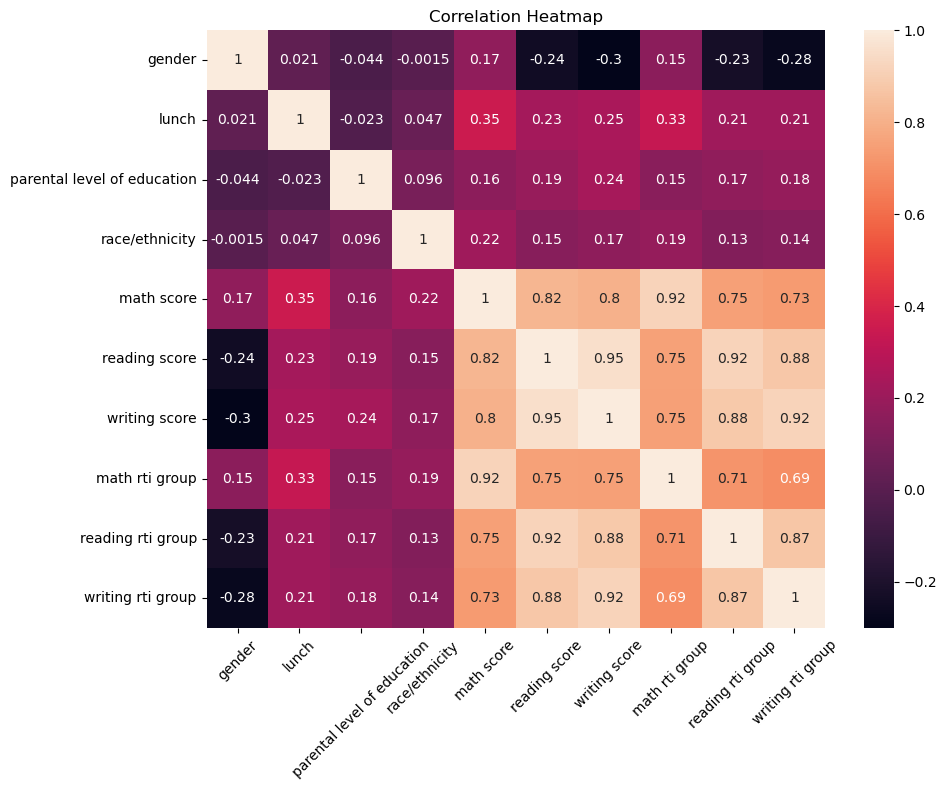

In [9]:
# function to clean and encode data
def clean_and_encode_data(df):
    # define encoding mappings
    education_mapping = {
        'some high school': 0,
        'high school': 1,
        'some college': 2,
        'associate\'s degree': 3,
        'bachelor\'s degree': 4,
        'master\'s degree': 5
    }

    race_mapping = {
        'group A': 0,
        'group B': 1,
        'group C': 2,
        'group D': 3,
        'group E': 4
    }

    rti_mapping = {
        'tier 3 intensive': 0,
        'tier 2 more support': 1,
        'more practice': 2,
        'enrich': 3
    }
    
    # map parental level of education and race/ethnicity
    df['parental level of education'] = df['parental level of education'].map(education_mapping)
    df['race/ethnicity'] = df['race/ethnicity'].map(race_mapping)
    
    # check if RTI group columns exist and map them if they do
    if 'math rti group' in df.columns:
        df['math rti group'] = df['math rti group'].map(rti_mapping)
    if 'reading rti group' in df.columns:
        df['reading rti group'] = df['reading rti group'].map(rti_mapping)
    if 'writing rti group' in df.columns:
        df['writing rti group'] = df['writing rti group'].map(rti_mapping)
    
    # encode lunch and gender using LabelEncoder
    label_encoder = LabelEncoder()
    df['lunch'] = label_encoder.fit_transform(df['lunch'])
    df['gender'] = label_encoder.fit_transform(df['gender'])
    
    return df


students_cleaned = clean_and_encode_data(students)

# create correlation matrix heatmap
students_corr = students_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(students_corr, annot=True)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Figure 2. The above visual shows a heatmap. The lighter areas show positive correlation whereas the darker areas show negative correlation. 

## Training the Model

Math RTI Grouping:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.93      0.97      0.95        29
           2       0.99      1.00      0.99        98
           3       1.00      1.00      1.00        57

    accuracy                           0.98       200
   macro avg       0.98      0.96      0.97       200
weighted avg       0.99      0.98      0.98       200

Reading RTI Grouping:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.93      0.96        27
           2       0.99      1.00      0.99        91
           3       1.00      1.00      1.00        69

    accuracy                           0.99       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.99      0.99      0.99       200

Writing RTI Grouping:
              precision    recall  f1-score   support

           0

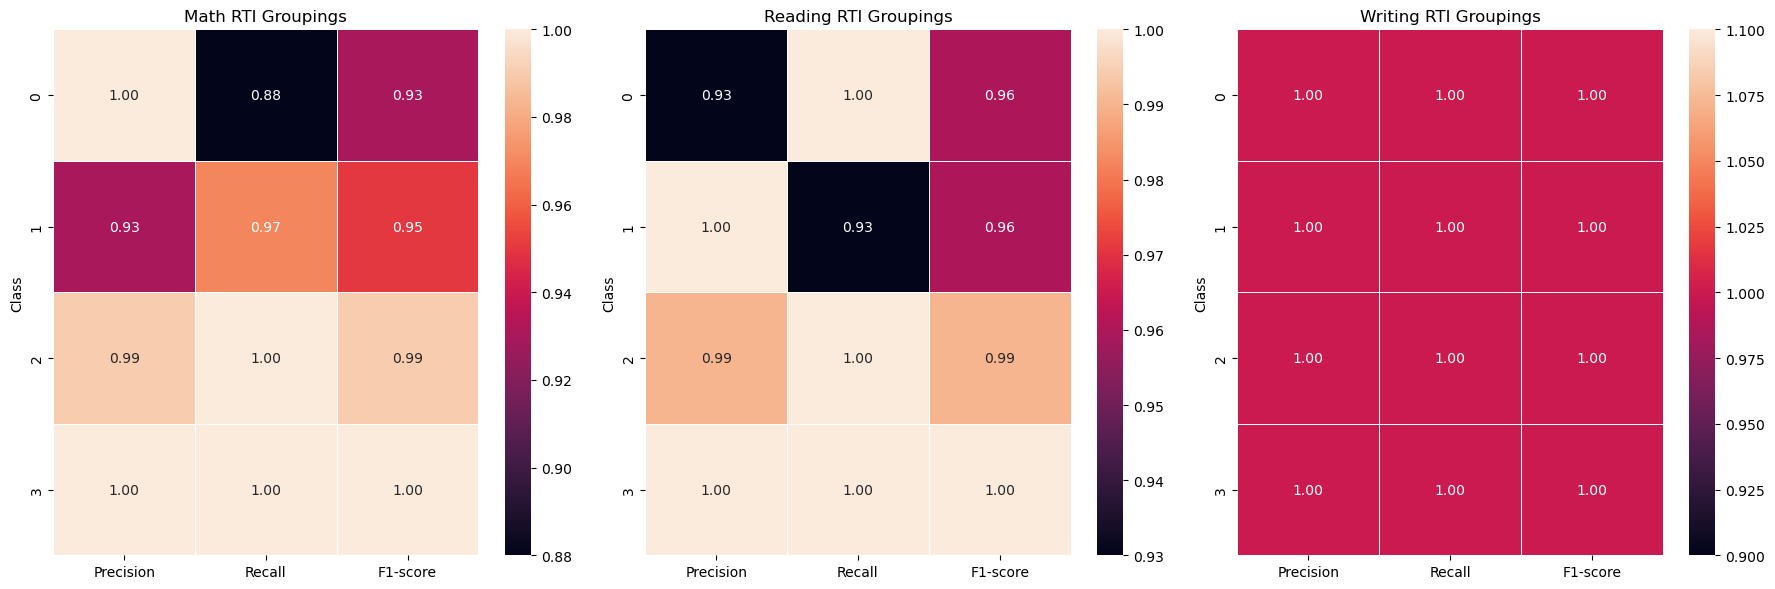

In [13]:
# shuffle the data and save
students_processed = students.sample(frac=1).reset_index(drop=True)
students_processed.to_csv('student_performance_processed.csv', index=False)

X = students_processed[['gender', 'lunch', 'parental level of education', 'race/ethnicity', 'math score', 'reading score', 'writing score']]
y_math = students_processed['math rti group']
y_reading = students_processed['reading rti group']
y_writing = students_processed['writing rti group']

# split data into training and test sets
X_train, X_test, y_math_train, y_math_test, y_reading_train, y_reading_test, y_writing_train, y_writing_test = train_test_split(
    X, y_math, y_reading, y_writing, test_size=0.2)

# initialize and train a Random Forest Classifier
model_math = RandomForestClassifier()
model_math.fit(X_train, y_math_train)

model_reading = RandomForestClassifier()
model_reading.fit(X_train, y_reading_train)

model_writing = RandomForestClassifier()
model_writing.fit(X_train, y_writing_train)

# make predictions on the test set for each subject
y_math_pred = model_math.predict(X_test)
y_reading_pred = model_reading.predict(X_test)
y_writing_pred = model_writing.predict(X_test)

# generate classification reports and print to screen
report_math = classification_report(y_math_test, y_math_pred)
report_reading = classification_report(y_reading_test, y_reading_pred)
report_writing = classification_report(y_writing_test, y_writing_pred)
print('Math RTI Grouping:')
print(report_math)
print('Reading RTI Grouping:')
print(report_reading)
print('Writing RTI Grouping:')
print(report_writing)

# function to parse classification report into class names and metrics
def parse_classification_report(report):
    report_io = StringIO(report)
    class_metrics = []
    for line in report_io:
        line_data = line.strip().split()
        if len(line_data) > 0 and line_data[0].isdigit(): 
            class_name = line_data[0]
            precision = float(line_data[1])
            recall = float(line_data[2])
            f1_score = float(line_data[3])
            class_metrics.append([class_name, precision, recall, f1_score])
    return class_metrics

# parse classification reports
metrics_math = parse_classification_report(report_math)
metrics_reading = parse_classification_report(report_reading)
metrics_writing = parse_classification_report(report_writing)

# plotting the heatmaps
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(pd.DataFrame(metrics_math, columns=['Class', 'Precision', 'Recall', 'F1-score']).set_index('Class'),
            annot=True, fmt=".2f", linewidths=.5)
plt.title('Math RTI Groupings')

plt.subplot(1, 3, 2)
sns.heatmap(pd.DataFrame(metrics_reading, columns=['Class', 'Precision', 'Recall', 'F1-score']).set_index('Class'),
            annot=True, fmt=".2f", linewidths=.5)
plt.title('Reading RTI Groupings')

plt.subplot(1, 3, 3)
sns.heatmap(pd.DataFrame(metrics_writing, columns=['Class', 'Precision', 'Recall', 'F1-score']).set_index('Class'),
            annot=True, fmt=".2f", linewidths=.5)
plt.title('Writing RTI Groupings')

plt.tight_layout()
plt.show()

FIGURE 3. This heatmap shows the precision, recall, and F1-score of the models for each subject area.

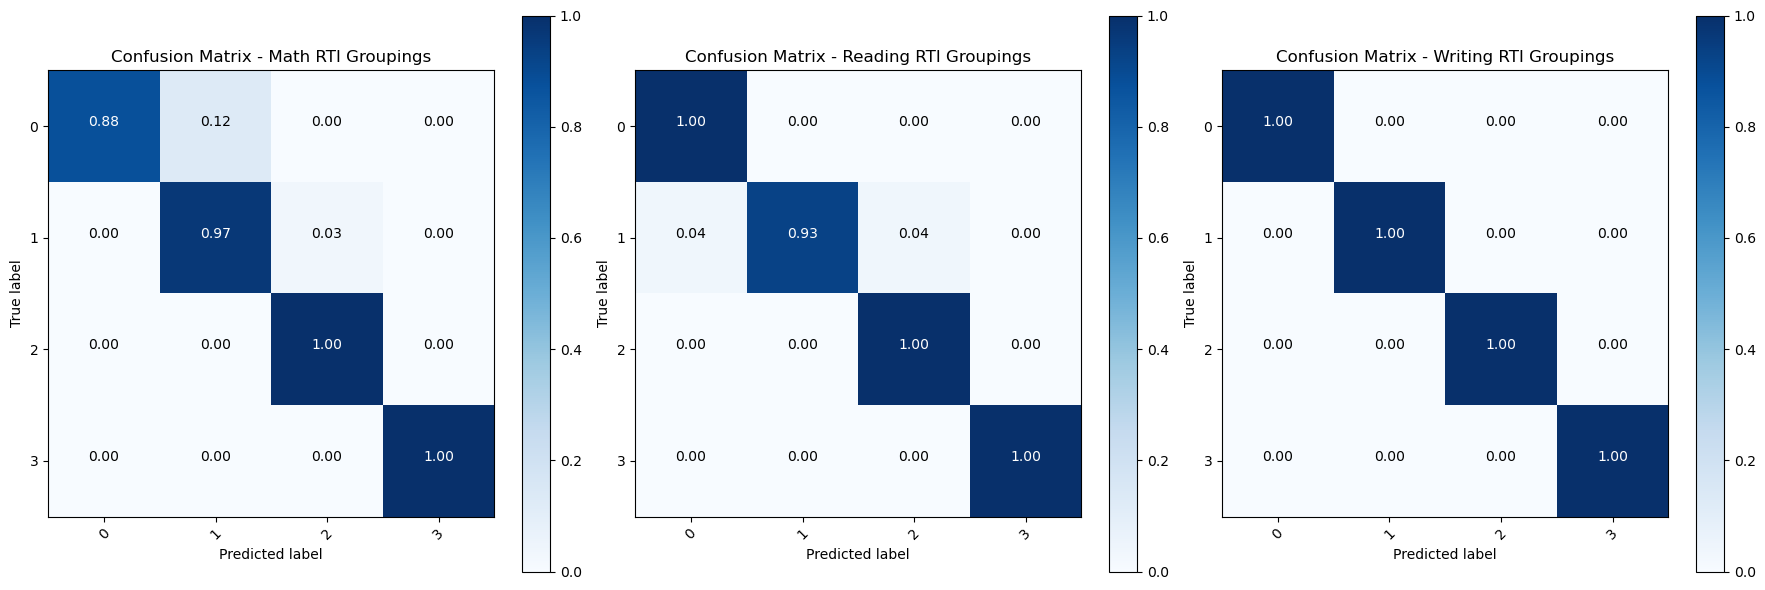

In [16]:
# compute confusion matrices
cm_math = confusion_matrix(y_math_test, y_math_pred, normalize='true')
cm_reading = confusion_matrix(y_reading_test, y_reading_pred, normalize='true')
cm_writing = confusion_matrix(y_writing_test, y_writing_pred, normalize='true')

# function to plot confusion matrix with percentages
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'  
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# plot confusion matrices with percentages
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plot_confusion_matrix(cm_math, classes=np.unique(y_math), title='Confusion Matrix - Math RTI Groupings')

plt.subplot(1, 3, 2)
plot_confusion_matrix(cm_reading, classes=np.unique(y_reading), title='Confusion Matrix - Reading RTI Groupings')

plt.subplot(1, 3, 3)
plot_confusion_matrix(cm_writing, classes=np.unique(y_writing), title='Confusion Matrix - Writing RTI Groupings')

plt.tight_layout()
plt.show()

In [18]:
# load sample grade-level data
sample_data = pd.read_csv('sample_grade_level_data.csv')

# prediction function
def predict_rti_groups(data, subject):
    cleaned_data = clean_and_encode_data(data)

    X_pred = cleaned_data[['gender', 'lunch', 'parental level of education', 'race/ethnicity', 'math score', 'reading score', 'writing score']]

    if subject == 'Math':
        predicted_group = model_math.predict(X_pred)
    elif subject == 'Reading':
        predicted_group = model_reading.predict(X_pred)
    elif subject == 'Writing':
        predicted_group = model_writing.predict(X_pred)
    else:
        predicted_group = None  

    return predicted_group

# UI setup
dropdown_subject = widgets.Dropdown(options=['Select a Subject', 'Math', 'Reading', 'Writing'])
execute_button = widgets.Button(description='Submit')
output = widgets.Output()

selected_subject = None

# event handler for subject selection
def handle_subject_change(change):
    global selected_subject
    selected_subject = change.new

# event handler for button click
def handle_submit_button_click(button):
    with output:
        clear_output()

        if selected_subject is not None:
            # predict RTI groups
            group_assignments = predict_rti_groups(sample_data, selected_subject)

            if group_assignments is not None:
                grouped_students = {}

                # iterate through both group_assignments and sample_data
                for idx, (group, student_row) in enumerate(zip(group_assignments, sample_data.iterrows())):
                    student_name = student_row[1]['name']  

                    # check if the group exists in the dictionary, if not, create it
                    if group not in grouped_students:
                        grouped_students[group] = []

                    # append the student name to the corresponding group
                    grouped_students[group].append(student_name)

            # print statement or return the grouped_students dictionary
            else:
                print(f"No predictions available for subject '{selected_subject}'")

            grouped_students = dict(sorted(grouped_students.items()))
            
            for group in grouped_students:
                students_in_group = grouped_students[group]
                if group == 0:
                    group_name = "Tier 3 Intensive"
                elif group == 1:
                    group_name = "Tier 2 More Support"
                elif group == 2:
                    group_name = "More Practice"
                else:
                    group_name = "Enrichment"
                print(f"Group {group_name}:")
                for student in students_in_group:
                    print(f" {student}")
            print('\n')
        
        else:
            print("Please select a subject to predict RTI groups.")

# attach event handlers
dropdown_subject.observe(handle_subject_change, names='value')
execute_button.on_click(handle_submit_button_click)

# display UI components
display(widgets.VBox([dropdown_subject, execute_button, output]))